# Assignment 13 Text Analytics

In this assignment, you will:
- Load and inspect a real-world business reviews dataset.
- Preprocess review text for NLP (tokenization, stopwords, lemmatization).
- Run sentiment analysis (rule-based and classifier-based) and compare to star ratings.
- Extract main topics from reviews using LDA and (optional) BERTopic.
- Interpret results in a business context (actionable insights).

## Why This Matters

Customer Reviews are critical for the survival of any business, but especially for restaurants.  Restaurants compete with not only all of the other restaurants in local area, but also with the option for customers to stay home and cook their own food.  Chefs and restaurant owners must monitor customer feedback to see if they should make changes to their pricing, menu options, restaurant amenities and seating/serving process.

You have been given 100 customer reviews.  Your job is to look for main topics that are mentioned, and whether those reviews have a postive, neutral or negative tone (sentiment).  

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Assignments/assignment_13_text_analytics.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



## Original Source: Dataset Description

The dataset you'll be using is a set of **restaurant reviews**, available from [Kaggle](https://www.kaggle.com/datasets/pruthvirajgshitole/e-commerce-purchases-and-reviews?utm_source=chatgpt.com&select=customer_purchase_data.csv).

Each row represents one customer review. The columns include:

- **Review** - text of the customer review
- **Liked** - indicates if the customer likes (1) or does not like (0) the restaurant

Please note that some reviews have commas and apostrophes, which can prevent the record from loading correctly.  You should verify that you have 1,000 reviews total.  

## 1. Load and Preview the Data

### Do the following:
1. Import your TSV file called `Restaurant_Reviews.tsv`.  Note that TSV is for Tab Separated Values.  This file does not use commas as a delimiter.
2. Use `pandas` to load and preview the dataset
3. Verify that all 1,000 rows were imported correctly
4. Calculate the overall percentage of reviews that "Liked" the restaurant
5. Create a visualization to show the percentage of likes versus non-likes


In [28]:
import pandas as pd
import csv

# Load the reviews
url = "https://raw.githubusercontent.com/Stan-Pugsley/is_4487_base/refs/heads/main/DataSets/Restaurant_Reviews.tsv"
df = pd.read_csv(url, sep='\t', quoting=csv.QUOTE_MINIMAL)

df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [29]:
#Verify that all 1,000 rows were imported correctly
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [30]:
percentage_liked = df['Liked'].mean() * 100
print(f"Percentage of reviews that 'Liked' the restaurant: {percentage_liked:.2f}%")

Percentage of reviews that 'Liked' the restaurant: 50.00%


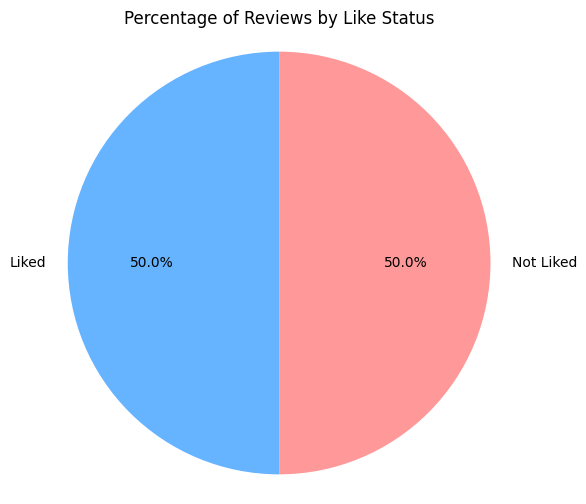

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate percentage of non-likes
percentage_not_liked = 100 - percentage_liked

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Category': ['Liked', 'Not Liked'],
    'Percentage': [percentage_liked, percentage_not_liked]
})

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(plot_df['Percentage'], labels=plot_df['Category'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title('Percentage of Reviews by Like Status')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## 2. Drop Columns Not Useful for Modeling

**Business framing:**  
To do text analysis, we need to remove all of the junk in the reviews.  This would include anything like punctuation, website URLs, emojis, etc.

### Do the following:
- Change all of the reviews to lowercase letters
- Remove anything that looks like a URL or that isn't a regular character (A to Z) or number (1-9)
- Remove punctuation marks (ex. !.,-:;)

### In Your Response:
1. What risks might occur if you included the review "junk" in your model?


In [32]:
#lowercase letters
df['Review'] = df['Review'].str.lower()
df.head()

,Review,Liked
0,wow... loved this place.,1
1,crust is not good.,0
2,not tasty and the texture was just nasty.,0
3,stopped by during the late may bank holiday of...,1
4,the selection on the menu was great and so wer...,1


In [33]:
#remove URLs and other characters
import re

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Remove non-alphanumeric characters and punctuation (keeping spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

df['Review'] = df['Review'].apply(clean_text)
df.head()

,Review,Liked
0,wow loved this place,1
1,crust is not good,0
2,not tasty and the texture was just nasty,0
3,stopped by during the late may bank holiday of...,1
4,the selection on the menu was great and so wer...,1


In [34]:
import re

# Remove punctuation marks explicitly
df['Review'] = df['Review'].str.replace(r'[!.,\-:;]', '', regex=True)
df.head()

,Review,Liked
0,wow loved this place,1
1,crust is not good,0
2,not tasty and the texture was just nasty,0
3,stopped by during the late may bank holiday of...,1
4,the selection on the menu was great and so wer...,1


### ✍️ Your Response: 🔧
1. If I had kept the 'junk' in the model,some things that would be affected is it could create unnecessary noise, it can create a misinterpretation of the sentiment ( !,?, all caps, etc), it can decrease the overall accuracy, and it can make it overall harder to interpret and make conclusions on.

## 3. Sentiment Analysis

**Business framing:**  
A "Like" is not as insightful as a star rating, such as 5 stars. It only has two values. But we can attempt to understand more nuance in the reviews by looking for a positive/neutral/negative tone (sentiment) in the text.   Then we can compare that to the "Likes" to see if they match.  

### Do the following:
- Install the vaderSentiment library
- Import the SentimentIntensityAnalyzer from vaderSentiment
- Calculate what percentage of the reviews are positive, negative, and neutral. The total percentages should add up to 100%

### In Your Response:
1. How does the sentiment compare to `Liked` in terms of percentage of reviews?
2. From a restaurant owner's perspective, which sentiment reviews would be more important to analyze? (positive, negative or neutral)


In [35]:
#import VADER
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [36]:
# import SentimentIntensityAnalyze & calculate persentages
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    vs = analyzer.polarity_scores(text)
    if vs['compound'] >= 0.05:
        return 'Positive'
    elif vs['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment'] = df['Review'].apply(get_sentiment)

sentiment_counts = df['Sentiment'].value_counts(normalize=True) * 100
print("Percentage of reviews by sentiment:")
print(sentiment_counts)

Percentage of reviews by sentiment:
Sentiment
Positive    50.6
Negative    25.5
Neutral     23.9
Name: proportion, dtype: float64


### ✍️ Your Response: 🔧
1. The sentiment compares to Liked because it was pretty accurate with the positive reviews at 50.6% but it broke down the not liked categery into negative (25.5%) and neutral (23.9%). This means that not all of the not liked category was necessarily negative.

2. From the resturant owner's perspective, the negative and neutral reviews are probably the most important to analyze to see what to improve on. The positive reviews would tell you what you're doing well at.

## 4. Topic Analysis - Text Preprocessing

**Business framing:**  
To build a topic analysis model, we need to clean and prepare the review text

### Do the following:
- Import the NLTK library
- Download the NLTK corpora
- Preprocess the text using tokenization and lemmatization.  Be sure to remove any stopwords along the way.
- Display the first 10 processed reviews

### In Your Response:
1. What is a corpora and how is it used for text analysis?
2. What would be the tokens in the first review? "Wow... Loved this place."
3. What does lemmatization do?  How will it help in this process?


In [37]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Ensure Punkt, WordNet, Stopwords, and punkt_tab are downloaded and available *before* using them
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

In [38]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(processed_tokens)

df['Processed_Review'] = df['Review'].apply(preprocess_text)

# Display the first 10 processed reviews
print("First 10 processed reviews:")
for i, review in enumerate(df['Processed_Review'].head(10)):
    print(f"{i+1}. {review}")

First 10 processed reviews:
1. wow loved place
2. crust good
3. tasty texture nasty
4. stopped late may bank holiday rick steve recommendation loved
5. selection menu great price
6. getting angry want damn pho
7. honeslty didnt taste fresh
8. potato like rubber could tell made ahead time kept warmer
9. fry great
10. great touch


### ✍️ Your Response: 🔧
1. From what I gathered, corpera is a large structured collection of text that is used for language analysis. Corpera is used to train models, extract linquistic features, develop language models, and evaluate models.

2. The tokensfrom the top 1 review,  after the capitalized letters and the punctuation were taken out,  was the the word 'this' which is a stop word.

3. Lemmmatization takes different versions of a word and simpllifies it into the basic dictionary form (running, ran, runs--> run). It will help the process because it reduces the different word variations (keeps the word as the same base word) and it can improve the accuracy.

## 5. Topic Analysis - Dictionary and Corpus

**Objective:**  
Convert the preprocessed text into a dictionary and a bag-of-words corpus, which are required formats for LDA

### Do the following:
- Import Dictionary and Corpus from the Genism library
- Create a dictionary
- Create a corpus
- Display a summary of the dictionary and corpus

### In Your Response:
1. What is a corpus and how is it useful?
2. How is a dictionary different from a corpus?

In [39]:
# Add code here 🔧

In [40]:
!pip install gensim
from gensim import corpora

# Tokenize the processed reviews into a list of lists of words
tokenized_reviews = [review.split() for review in df['Processed_Review']]

# Create a dictionary
dictionary = corpora.Dictionary(tokenized_reviews)

# Create a corpus (Bag of Words representation)
corpus = [dictionary.doc2bow(review) for review in tokenized_reviews]

In [41]:
# Display summary of the dictionary
print("Dictionary summary:")
print(f"Number of unique tokens: {len(dictionary)}")
print(f"First 10 dictionary entries: {list(dictionary.items())[:10]}")
print("\nCorpus summary (first 5 documents):")
for i, doc in enumerate(corpus[:5]):
    print(f"Document {i+1}: {doc}")

Dictionary summary:
Number of unique tokens: 1839
First 10 dictionary entries: [(0, 'loved'), (1, 'place'), (2, 'wow'), (3, 'crust'), (4, 'good'), (5, 'nasty'), (6, 'tasty'), (7, 'texture'), (8, 'bank'), (9, 'holiday')]

Corpus summary (first 5 documents):
Document 1: [(0, 1), (1, 1), (2, 1)]
Document 2: [(3, 1), (4, 1)]
Document 3: [(5, 1), (6, 1), (7, 1)]
Document 4: [(0, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]
Document 5: [(16, 1), (17, 1), (18, 1), (19, 1)]


### ✍️ Your Response: 🔧
1. A corpus turns the words into numbers based on their frequencies.

2. A dictionary is different from a corpus because a dictionary is just a list of all the unique words in the dataset, while a corpus counts the frequency of the words.

## 6. Topic Analysis - Build LDA Model

**Objective:**  
Apply the LDA model to the corpus to identify main topics.

### Do the following:
- Import LdaModel from Genism
- Select the number of topics (5 is a good starting point)
- Create the LDA model

### In Your Response:
1. In what cases would you want to use more than 5 topics?  
2. How would you know if you have too many topics?

NOTE: You may receive an error about training "not converging".  You can ignore that error for this assignment. (Let's keep it simple)


In [42]:
# Add code here 🔧

In [43]:
#import the LDA Model
from gensim.models import LdaModel

# Select the number of topics
num_topics = 5

# Create the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=15, random_state=42)
print("LDA model created successfully.")

LDA model created successfully.


### ✍️ Your Response: 🔧
1. You would want to use more than 5 topics if the dataset is super large and diverse. You would need more than 5 topics for these datasets to get more detailed insights.

2. You would know if you have too many topics if the topics become overlapping (repetitive themes), if there are only a few words inside each topic, or if adding new topics doesn't show any new insights.

## 7. Summarize the Topics

**Business framing:**  
Now comes one of the most challenging steps.  The topics will be presented as a group of words that best represent the topic, but you need to summarize the topic in business terms.   

### Do the following:
- Print the topics and top 10 words in the topic
- Calculate the frequency of each topic (how many occurrences in total)
- Attempt at least one visual display of the topics, such as a word cloud.  (Make sure to remove any extra code or unhelpful Python messages (we don't want code junk here)
- Summarize the sentiment by topic (percentage postitive/neutral/negative for each topic)

### In Your Response:
1. Give each topic a 2-3 word name.  You should list the topic number and a name that you will create that summarize the words used.  For example, "Topic #1 - Slow Service"


In [44]:
# Add code here 🔧

In [45]:
#print top 10 words in the topic
print("LDA Model Topics:")
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic #{idx}: {topic}")

LDA Model Topics:
Topic #0: 0.024*"good" + 0.020*"place" + 0.019*"food" + 0.016*"dont" + 0.010*"time" + 0.010*"would" + 0.010*"go" + 0.009*"best" + 0.009*"star" + 0.007*"back"
Topic #1: 0.016*"good" + 0.015*"place" + 0.014*"also" + 0.012*"friendly" + 0.012*"time" + 0.009*"ive" + 0.007*"waited" + 0.007*"go" + 0.007*"back" + 0.006*"pizza"
Topic #2: 0.015*"place" + 0.011*"minute" + 0.011*"great" + 0.011*"food" + 0.010*"amazing" + 0.009*"like" + 0.007*"taste" + 0.007*"pretty" + 0.006*"ordered" + 0.006*"flavor"
Topic #3: 0.033*"food" + 0.024*"back" + 0.014*"like" + 0.013*"ever" + 0.012*"wont" + 0.011*"service" + 0.008*"one" + 0.008*"best" + 0.007*"go" + 0.007*"even"
Topic #4: 0.039*"service" + 0.025*"great" + 0.023*"place" + 0.016*"food" + 0.015*"good" + 0.009*"restaurant" + 0.008*"time" + 0.008*"delicious" + 0.007*"well" + 0.007*"definitely"


In [46]:
import numpy as np
# Calculate the frequency of each topic (how many occurrences in total)
# Get the dominant topic for each review
def get_dominant_topic(ldamodel, corpus):
    topic_per_document = []
    for i, corp in enumerate(corpus):
        # Get topic distributions for each document
        topic_distribution = ldamodel[corp]
        # Sort topics by probability and get the most dominant one
        if topic_distribution:
            dominant_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0][0]
        else:
            dominant_topic = -1  # Assign -1 if no topics found for an empty document
        topic_per_document.append(dominant_topic)
    return topic_per_document

df['Dominant_Topic'] = get_dominant_topic(lda_model, corpus)

# Calculate the frequency of each topic
topic_counts = df['Dominant_Topic'].value_counts().sort_index()
topic_percentages = df['Dominant_Topic'].value_counts(normalize=True).sort_index() * 100

print("\nFrequency of each topic:")
for topic_id, count in topic_counts.items():
    print(f"Topic #{topic_id}: Count = {count}, Percentage = {topic_percentages[topic_id]:.2f}%")



Frequency of each topic:
Topic #0: Count = 207, Percentage = 20.70%
Topic #1: Count = 161, Percentage = 16.10%
Topic #2: Count = 177, Percentage = 17.70%
Topic #3: Count = 209, Percentage = 20.90%
Topic #4: Count = 246, Percentage = 24.60%


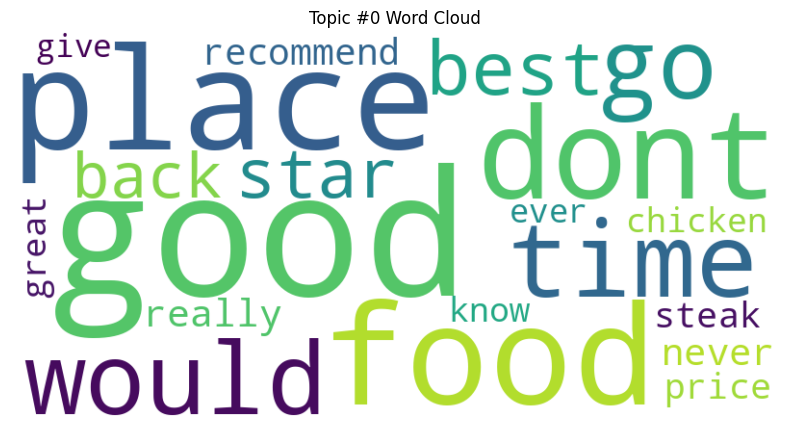

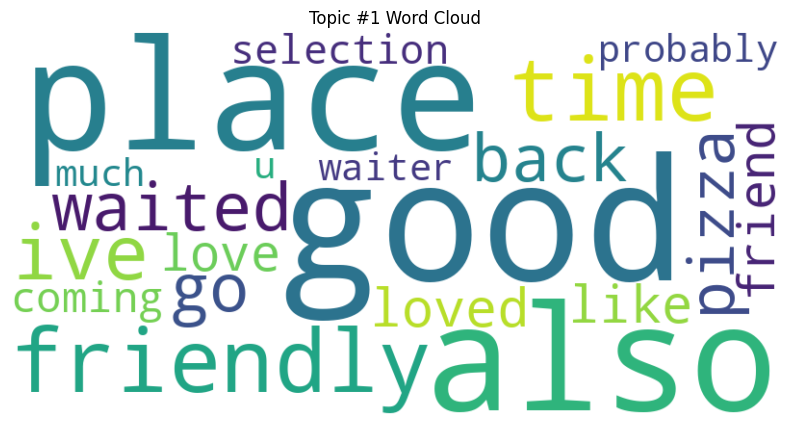

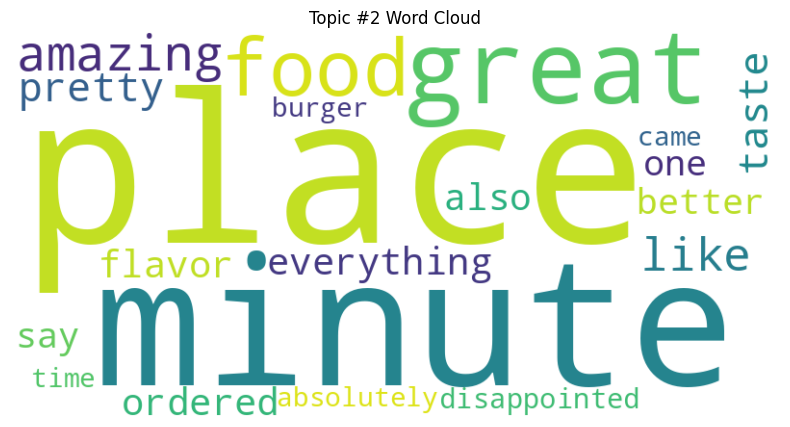

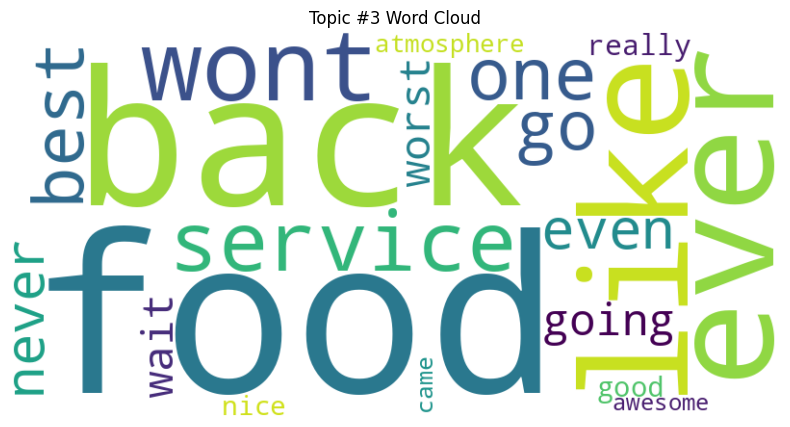

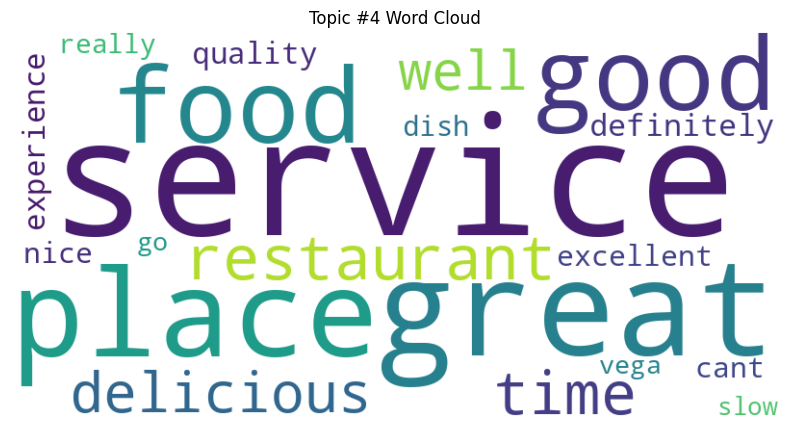

In [47]:
#Visualize the topics
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate a word cloud for each topic
for i, topic in lda_model.show_topics(formatted=False, num_topics=num_topics, num_words=20):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(topic))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Topic #{i} Word Cloud')
    plt.axis('off')
    plt.show()

In [48]:
# Summarize the sentiment
sentiment_by_topic = df.groupby(['Dominant_Topic', 'Sentiment']).size().unstack(fill_value=0)
sentiment_by_topic_percentage = sentiment_by_topic.apply(lambda x: x / x.sum() * 100, axis=1)

print("\nSentiment summary by topic (percentages):\n")
print(sentiment_by_topic_percentage.round(2))


Sentiment summary by topic (percentages):

Sentiment       Negative  Neutral  Positive
Dominant_Topic                             
0                  22.71    29.47     47.83
1                  24.84    24.22     50.93
2                  27.68    22.60     49.72
3                  29.19    28.23     42.58
4                  23.58    16.26     60.16


### ✍️ Your Response: 🔧
List your topics and names here:

Topic 0: Good quality food
Topic 1:Good service
Topic 2: Overall good experience
Topic 3: Bad service
Topic 4: good food and good atmosphere


## 8. Reflect and Recommend

**Business framing:**  
Ultimately, the value of your model comes from how well it can guide business decisions. Use your results to make real-world recommendations.

### In Your Response:
1. What business question did your model help answer?
2. What would you recommend to this restaurant to improve customer satisfaction?
3. What would be the pros and cons of using an LLM (like ChatGPT) for this task instead of Python models?
4. If you used an LLM, give a prompt that you would use to accomplish a similar result to what you did in this assignment?  (remember to set the context, specify the output and explain the objectives)


### ✍️ Your Response: 🔧
1. This model helped answe the business questions such as overall customer sentiment as well as what the main topics discussed in the reviews were.

2. Topic 3 had some negative probably pertaining to poor service. I would probably adresss this issue first and then I would renforce some of the strengths like the positive things on the service and food. Additionally, there was some comments on time so maybe see if you need to make changes to the resturaunt efficiency.

3. The pros of using a LLM model as oposed to python for this is there is no coding involved, it is beeter at understanding complex words and gives direct readable insights. Some cons are LLMs can be expensive for big datasets, there are privacy concerns, and they sometimes 'halucinate' or show biases.

4. A prompt that I would use for a LLM is I would tell it that these customer reviews are coming from a resturaunt (say what type of food and if its sit down, togo, etc) then I would tell it to give me the overall sentiment, some repeated reviews (positive and negative) and then to provide actionable insights.

## Submission Instructions
✅ Checklist:
- All code cells run without error
- All markdown responses are complete
- Submit on Canvas as instructed

In [49]:
!jupyter nbconvert --to html "assignment_11_LastnameFirstname.ipynb"

[NbConvertApp] WARNING | pattern 'assignment_11_LastnameFirstname.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes